In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from src.offline_pg import ISPG
from src.offline_ql import discrete_PQL

## Compute IS weights

In [6]:
with open("data/s45da_mimic_train_episodes", 'rb') as f:
    train_dataset = pickle.load(f)

In [7]:
with open("data/s45da_mimic_val_episodes", 'rb') as f:
    val_dataset = pickle.load(f)

In [8]:
with open("data/s45da_mimic_test_episodes", 'rb') as f:
    test_dataset = pickle.load(f)

In [9]:
# computer IS weights: select pibs, compute pies
def compute_is_weights(dataset, q_policy):
    n = dataset["observations"].shape[0]
    horizon = dataset["observations"].shape[1]
    
    rewards = dataset["rewards"][:,:,0]
    
    pies = np.zeros((n, horizon))
    pibs = np.zeros((n, horizon))
    length = np.zeros((n))
    
    for idx in range(n):
        for t in range(horizon):
            pie = q_policy.get_prob(dataset["observations"][idx,t,:], dataset["estm_pibs"][idx,t,:], 
                                    dataset["nn_action_dist"][idx,t,:])
            a = dataset["actions"][idx,t,0]
            
            pies[idx,t] = pie[a]
            pibs[idx,t] = dataset["pibs"][idx,t,a]
    
            if not dataset["not_done"][idx,t,0]:
                length[idx] = t+1
                break
    return pibs, pies, rewards, length

In [10]:
def wis_ope(pibs, pies, rewards, length, weighted=True):
    n = pibs.shape[0]
    weights = np.ones((n,20))
    
    for i in range(n):
        last = 1
        for t in range(int(length[i])):
            weights[i,t] = last*(pies[i,t]/pibs[i,t])    
            last = weights[i,t]
        weights[i,length[i]:] = weights[i,length[i]-1]
    weights = np.clip(weights, 0, 1e3)
    if weighted:
        weights_norm = weights.sum(axis=0)
    else:
        weights_norm = weights.shape[0]
    weights /= weights_norm
    
    return (weights[:,-1] * rewards.sum(axis=-1)).sum(axis=0), weights[:,-1]

In [11]:
from scipy.stats import norm, t
def bca_bootstrap(pibs, pies, rewards, length, alpha=0.05, B = 1000):
    wis_list = []
    n_patients = pibs.shape[0]
    n_subsample = n_patients
    for b in range(B):
        ids = np.random.choice(n_patients, n_subsample)
        sam_rewards = rewards[ids,:]
        sam_pibs = pibs[ids,:]
        sam_pies = pies[ids,:]
        sam_length = length[ids]
        wis_pie, _ = wis_ope(sam_pibs, sam_pies, sam_rewards, sam_length)
        wis_list.append(wis_pie)
    y = []
    for i in range(n_patients):
        sam_rewards = np.delete(rewards,i,axis=0)
        sam_pibs = np.delete(pibs,i,axis=0)
        sam_pies = np.delete(pies,i,axis=0)
        sam_length = np.delete(length,i,axis=0)
        wis_pie, _ = wis_ope(sam_pibs, sam_pies, sam_rewards, sam_length)
        y.append(wis_pie)
        
    wis_list = np.array(wis_list)
    wis_list = np.sort(wis_list)
    y = np.array(y)
    avg,_ = wis_ope(pibs, pies, rewards, length)
    
    ql, qu = norm.ppf(alpha), norm.ppf(1-alpha)

    # Acceleration factor
    num = np.sum((y.mean() - y)**3)
    den = 6*np.sum((y.mean() - y)**2)**1.5
    ahat = num / den

    # Bias correction factor
    zhat = norm.ppf(np.mean(wis_list < avg))
    a1 = norm.cdf(zhat + (zhat + ql)/(1-ahat*(zhat+ql)))
    a2 = norm.cdf(zhat + (zhat + qu)/(1-ahat*(zhat+qu)))

    print('Accel: %0.3f, bz: %0.3f, a1: %0.3f, a2: %0.3f' % (ahat, zhat, a1, a2))
    return np.quantile(wis_list, [a1, a2]), wis_list

In [12]:
def bca_bootstrap_mc(x, alpha=0.05, B=1000):
    values = []
    n_patients = x.shape[0]
    n_subsample = n_patients
    for b in tqdm(range(B)):
        ids = np.random.choice(n_patients, n_subsample)
        value = x[ids,:].mean()
        values.append(value)
    y = []
    for i in range(n_patients):
        x_sub = np.delete(x,i,axis=0)
        value = x_sub.mean()
        y.append(value)
        
    values = np.array(values)
    values = np.sort(values)
    y = np.array(y)
    avg = x.mean()
    
    ql, qu = norm.ppf(alpha), norm.ppf(1-alpha)

    # Acceleration factor
    num = np.sum((y.mean() - y)**3)
    den = 6*np.sum((y.mean() - y)**2)**1.5
    ahat = num / den

    # Bias correction factor
    zhat = norm.ppf(np.mean(values < avg))
    a1 = norm.cdf(zhat + (zhat + ql)/(1-ahat*(zhat+ql)))
    a2 = norm.cdf(zhat + (zhat + qu)/(1-ahat*(zhat+qu)))

    print('Accel: %0.3f, bz: %0.3f, a1: %0.3f, a2: %0.3f' % (ahat, zhat, a1, a2))
    return np.quantile(values, [a1, a2]), values

## Plot Result

### Pick the Best Model on Validation Set

In [13]:
ESS_lb = 200

In [45]:
def get_model_from_param(param, ess_constraint=True):
    
    FEATURES_UB = [20, 0.5000, 0.5000, 5.1672, 2.7543, 7.9158, 2.7949, 5.2763, 7.1967,
                      9.0866, 11.8737, 7.8319, 236.7704, 3.0286, 9.9485, 8.7237, 6.2627, 15.6281,
                      8.5191, 13.5491, 6.1870, 40.5525, 10.0892, 6.7538, 20.4172, 8.5691, 6.5705,
                      12.9162, 6.6171, 17.8618, 29.6399, 5.0306, 11.4043, 40.8348, 5.0392, 2.3167,
                      23.0958, 7.7701, 7.5767, 5.6300, 4.9695, 4.2235, 1.7962, 2.8099, 2.0322]
    
    if param["name"] in {"POELA", "POELA-IS"}:
        settings = f"PG_{param['env']}_masknn_action_dist_weightedTrueam0.0"\
                   f"thresh{param['thresh']}var{param['var_coeff']}clip0.01seed{param['seed']}"
        model = ISPG(state_dim=45, num_actions=25, device="cpu", 
                     threshold=10000, action_mask_type="nn_action_dist") #threshold=param['thresh']     
    
    elif param["name"] in {"norm-POEM", "norm-IS", "POELA-kNN", "POELA-kNN-IS", "norm-POEM*", "norm-IS*"}:
        settings = f"PG_{param['env']}_maskstep_weightedTrueam0.0"\
                   f"thresh{param['thresh']}var{param['var_coeff']}clip0.01seed{param['seed']}"
        model = ISPG(state_dim=45, num_actions=25, device="cpu", 
                     threshold=param['thresh'], action_mask_type="step")
    
    elif param["name"] == "BCQ":
        settings = f"BCQ_{param['env']}_thresh{param['thresh']}_seed{param['seed']}"
        model = discrete_PQL(num_actions=25, state_dim=45, device="cpu", state_clipping=False, 
                             max_state=FEATURES_UB, action_threshold=param['thresh'], log_pibs=False)
    
    elif param["name"] == "PQL":
        settings = f"PQL_{param['env']}_thresh{param['thresh']}_seed{param['seed']}"
        model = discrete_PQL(num_actions=25, state_dim=45, device="cpu", state_clipping=True, 
                             max_state=FEATURES_UB, action_threshold=param['thresh'], log_pibs=False)
        
    if "POELA" in param["name"] or "norm-" in param["name"]:
        val_score = np.load(f"./results/{settings}_val_wis_scores.npy")
        train_score = np.load(f"./results/{settings}_train_wis_scores.npy")
        #print(param['thresh'], param['var_coeff'], param['seed'], train_score.shape, val_score.shape)
        #print(np.max(val_score[:,0]), np.max((val_score[:,-1]>200)*val_score[:,0]), val_score[-1,0])
        if ess_constraint and np.sum(val_score[:,-1]>200):
            model.load(f"models/{settings}_best_")
            train_score = train_score[np.argmax((val_score[:,-1]>200)*val_score[:,0]),:]
            val_score = val_score[np.argmax((val_score[:,-1]>200)*val_score[:,0]),:]
        else:
            model.load(f"models/{settings}_best_noess_")
            train_score = train_score[np.argmax(val_score[:,0]),:]
            val_score = val_score[np.argmax(val_score[:,0]),:]
    else:
        val_score = np.load(f"./results/{settings}_val_scores.npy")
        train_score = np.load(f"./results/{settings}_q_scores.npy")
        #print(np.argmax(val_score[:,0]), np.argmax((val_score[:,-1]>200)*val_score[:,0]))
        if ess_constraint and np.sum(val_score[:,-1]>200):
            model.load(f"models/{settings}_best_")
            train_score = train_score[np.argmax((val_score[:,-1]>200)*val_score[:,0])]
            val_score = val_score[np.argmax((val_score[:,-1]>200)*val_score[:,0]),:]
        else:
            model.load(f"models/{settings}_best_noess_")
            train_score = train_score[np.argmax(val_score[:,0])]
            val_score = val_score[np.argmax(val_score[:,0]),:]
    
    return model, val_score, train_score

In [34]:
seeds = [1,2,3,4,5]

In [35]:
# Our method
var_coeff_list = [0.0, 0.1, 1.0, 10.0]
threshold_list = [0.4, 0.6, 0.8, 1.0]

best_wis = -100
best_reliable_wis = -100
for threshold in threshold_list:
    for var_coeff in var_coeff_list:
        for seed in seeds:
            param = {"name": "POELA", "env": "mimic45", "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
            model, score, _ = get_model_from_param(param)
        
            wis_pie = score[0]
            ESS = score[-1]
        
            if ESS >= ESS_lb and wis_pie > best_reliable_wis:
                best_reliable_wis = wis_pie
                ours_rel_param = param
                print("reliable wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
                
            model, score, _ = get_model_from_param(param, False)
            wis_pie = score[0]
            ESS = score[-1]
            if wis_pie > best_wis:
                best_wis = wis_pie
                ours_param = param
                print("best wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)

best wis: 97.38  ESS: 91.02 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.0, 'seed': 1}
best wis: 97.87  ESS: 77.87 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.0, 'seed': 3}
best wis: 98.5  ESS: 85.41 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.1, 'seed': 3}
best wis: 99.25  ESS: 88.19 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 1.0, 'seed': 3}
reliable wis: 93.6  ESS: 376.5 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 1}
reliable wis: 93.87  ESS: 374.5 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 4}
reliable wis: 94.01  ESS: 407.28 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.1, 'seed': 2}


In [36]:
# Our method no var
var_coeff_list = [0.0]
threshold_list = [0.4, 0.6, 0.8, 1.0]

best_wis = -100
best_reliable_wis = -100
for threshold in threshold_list:
    for var_coeff in var_coeff_list:
        for seed in seeds:
            param = {"name": "POELA-IS", "env": "mimic45", "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
            model, score, _ = get_model_from_param(param)
        
            wis_pie = score[0]
            ESS = score[-1]
        
            if ESS >= ESS_lb and wis_pie > best_reliable_wis:
                best_reliable_wis = wis_pie
                ours_novar_rel_param = param
                print("New best reliable wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
            model, score, _ = get_model_from_param(param, False)
            wis_pie = score[0]
            ESS = score[-1]
            if wis_pie > best_wis:
                best_wis = wis_pie
                ours_novar_param = param
                print("New wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)

New wis: 97.38  ESS: 91.02 at: {'name': 'POELA-IS', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.0, 'seed': 1}
New wis: 97.87  ESS: 77.87 at: {'name': 'POELA-IS', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.0, 'seed': 3}
New best reliable wis: 93.6  ESS: 376.5 at: {'name': 'POELA-IS', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 1}
New best reliable wis: 93.87  ESS: 374.5 at: {'name': 'POELA-IS', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 4}


In [37]:
# kNN
var_coeff_list = [0.0, 0.1, 1.0, 10.0]
threshold_list = [0.01, 0.02, 0.05, 0.1]

best_wis = -100
best_reliable_wis = -100
for threshold in threshold_list:
    for var_coeff in var_coeff_list:
        for seed in seeds:
            try:
                param = {"name": "POELA-kNN", "env": "mimic45", "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
                model, score, _ = get_model_from_param(param)
            except:
                continue
            wis_pie = score[0]
            ESS = score[-1]
        
            if ESS >= ESS_lb and wis_pie > best_reliable_wis:
                best_reliable_wis = wis_pie
                knn_rel_param = param
                print("New best reliable wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
            
            model, score, _ = get_model_from_param(param, False)
            wis_pie = score[0]
            #print(wis_pie)
            ESS = score[-1]
            if wis_pie > best_wis:
                best_wis = wis_pie
                knn_param = param
                print("New wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)


New wis: 99.37  ESS: 14.23 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 0.0, 'seed': 1}
New wis: 99.98  ESS: 11.81 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 0.0, 'seed': 3}
New best reliable wis: 88.81  ESS: 744.85 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 10.0, 'seed': 1}
New best reliable wis: 88.82  ESS: 771.94 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 10.0, 'seed': 4}
New best reliable wis: 89.94  ESS: 402.48 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 10.0, 'seed': 5}
New best reliable wis: 90.31  ESS: 227.4 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.02, 'var_coeff': 0.1, 'seed': 1}
New best reliable wis: 90.82  ESS: 272.41 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.02, 'var_coeff': 10.0, 'seed': 4}
New best reliable wis: 92.21  ESS: 378.09 at: {'name': 'POELA-kNN', 'env': 'mimic45', 'thresh': 0.02, 'var_coe

In [38]:
# pg
var_coeff_list = [0.0, 0.1, 1.0, 10.0]
threshold_list = [0.01]

best_wis = -100
best_reliable_wis = -100
for threshold in threshold_list:
    for var_coeff in var_coeff_list:
        for seed in seeds:
            param = {"name": "norm-POEM", "env": "mimic45", "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
            model, score, _ = get_model_from_param(param)
            wis_pie = score[0]
            ESS = score[-1]
        
            if ESS >= ESS_lb and wis_pie > best_reliable_wis:
                best_reliable_wis = wis_pie
                npoem_rel_param = param
                print("New best reliable wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
            model, score, _ = get_model_from_param(param, False)
            wis_pie = score[0]
            #print(wis_pie)
            ESS = score[-1]
            if wis_pie > best_wis:
                best_wis = wis_pie
                npoem_param = param
                print("New wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)


New wis: 99.37  ESS: 14.23 at: {'name': 'norm-POEM', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 0.0, 'seed': 1}
New wis: 99.98  ESS: 11.81 at: {'name': 'norm-POEM', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 0.0, 'seed': 3}
New best reliable wis: 88.81  ESS: 744.85 at: {'name': 'norm-POEM', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 10.0, 'seed': 1}
New best reliable wis: 88.82  ESS: 771.94 at: {'name': 'norm-POEM', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 10.0, 'seed': 4}
New best reliable wis: 89.94  ESS: 402.48 at: {'name': 'norm-POEM', 'env': 'mimic45', 'thresh': 0.01, 'var_coeff': 10.0, 'seed': 5}


In [39]:
# BCQ
threshold_list = [0.0, 0.01, 0.05, 0.1, 0.3]

best_wis = -100
best_reliable_wis = -100
for threshold in threshold_list:
    for seed in seeds:
        param = {"name": "BCQ", "env": "mimic45", "thresh": threshold, "seed": seed}
        model, score, _ = get_model_from_param(param)
        wis_pie = score[0]
        ESS = score[-1]
        
        if ESS >= ESS_lb and wis_pie > best_reliable_wis:
            best_reliable_wis = wis_pie
            bcq_rel_param = param
            print("New best reliable wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
        
        model, score, _ = get_model_from_param(param, False)
        wis_pie = score[0]
        ESS = score[-1]
        if wis_pie > best_wis:
            best_wis = wis_pie
            bcq_param = param
            print("New wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)

New wis: 100.0  ESS: 1.0 at: {'name': 'BCQ', 'env': 'mimic45', 'thresh': 0.0, 'seed': 1}
New wis: 100.0  ESS: 1.0 at: {'name': 'BCQ', 'env': 'mimic45', 'thresh': 0.0, 'seed': 2}
New best reliable wis: 90.1  ESS: 235.56 at: {'name': 'BCQ', 'env': 'mimic45', 'thresh': 0.01, 'seed': 1}
New best reliable wis: 90.55  ESS: 266.1 at: {'name': 'BCQ', 'env': 'mimic45', 'thresh': 0.01, 'seed': 3}
New best reliable wis: 91.24  ESS: 226.76 at: {'name': 'BCQ', 'env': 'mimic45', 'thresh': 0.01, 'seed': 4}


In [40]:
# PQL
threshold_list = [0.0, 0.01, 0.05, 0.1, 0.3]

best_wis = -100
best_reliable_wis = -100
for threshold in threshold_list:
    for seed in seeds:
        param = {"name": "PQL", "env": "mimic45", "thresh": threshold, "seed": seed}
        model, score, _ = get_model_from_param(param)
        wis_pie = score[0]
        ESS = score[-1]
        
        if ESS >= ESS_lb and wis_pie > best_reliable_wis:
            best_reliable_wis = wis_pie
            pql_rel_param = param
            print("New best reliable wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
        
        model, score, _ = get_model_from_param(param, False)
        wis_pie = score[0]
        ESS = score[-1]
        if wis_pie > best_wis:
            best_wis = wis_pie
            pql_param = param
            print("New wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)

New wis: 100.0  ESS: 1.0 at: {'name': 'PQL', 'env': 'mimic45', 'thresh': 0.0, 'seed': 1}
New best reliable wis: 89.77  ESS: 243.64 at: {'name': 'PQL', 'env': 'mimic45', 'thresh': 0.01, 'seed': 1}
New best reliable wis: 91.18  ESS: 234.14 at: {'name': 'PQL', 'env': 'mimic45', 'thresh': 0.01, 'seed': 4}


### Compute WIS and BCa confidence interval on test set

In [51]:
CIs = []
ESSs = []
wis_tests = []

for param in [ours_param, ours_novar_param, knn_param, npoem_param, bcq_param, pql_param]:
    model, val_score, _ = get_model_from_param(param, False)
    pibs, pies, rewards, length = compute_is_weights(test_dataset, model)
    length = length.astype(int)
    wis_pie, weights = wis_ope(pibs, pies, rewards, length)

    v_pib = rewards.sum(axis=-1).mean(axis=0)
    ESS = 1/(np.sum(weights**2,axis=0))
    lb_ub, wis_list = bca_bootstrap(pibs, pies, rewards, length, alpha=0.05)

    wis_tests.append(wis_pie)
    ESSs.append(ESS)
    CIs.append(lb_ub)
    print("WIS:", wis_pie)
    print("ESS:", ESS)
    print(lb_ub)

Accel: -0.018, bz: -0.033, a1: 0.039, a2: 0.938
WIS: 87.63949777272308
ESS: 528.1810651990509
[85.06 90.  ]
Accel: -0.017, bz: -0.048, a1: 0.037, a2: 0.934
WIS: 86.2944708138815
ESS: 491.71875054933196
[83.51 88.59]
Accel: -0.070, bz: -0.116, a1: 0.017, a2: 0.897
WIS: 82.36211922281583
ESS: 21.239846409705695
[62.65 92.78]
Accel: -0.070, bz: -0.050, a1: 0.024, a2: 0.917
WIS: 82.36211922281583
ESS: 21.239846409705695
[64.34 93.6 ]
Accel: -0.078, bz: -0.068, a1: 0.020, a2: 0.909
WIS: 83.78235170786718
ESS: 9.505121394305865
[52.23 99.99]
Accel: 0.164, bz: 0.108, a1: 0.132, a2: 0.995
WIS: 96.32784699205546
ESS: 1.2731855860578365
[ 62.41 100.  ]


In [44]:
ESSs_noess = np.array(ESSs)
CIs_noess = np.array(CIs)
wis_tests_noess = np.array(wis_tests)

In [45]:
CIs = []
ESSs = []
wis_tests = []

# for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
#               npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
#               bcq_rel_param, pql_rel_param]:
for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, npoem_rel_param, bcq_rel_param, pql_rel_param]:
    model, _, _ = get_model_from_param(param)
    pibs, pies, rewards, length = compute_is_weights(test_dataset, model)
    length = length.astype(int)
    wis_pie, weights = wis_ope(pibs, pies, rewards, length)

    v_pib = rewards.sum(axis=-1).mean(axis=0)
    ESS = 1/(np.sum(weights**2,axis=0))
    lb_ub, wis_list = bca_bootstrap(pibs, pies, rewards, length, alpha=0.05)

    wis_tests.append(wis_pie)
    ESSs.append(ESS)
    CIs.append(lb_ub)
    print("WIS:", wis_pie)
    print("ESS:", ESS)
    print(lb_ub)

Accel: -0.021, bz: 0.048, a1: 0.054, a2: 0.954
WIS: 91.46953279566598
ESS: 624.9277837733208
[89.5919446  93.24882146]
Accel: -0.024, bz: -0.005, a1: 0.043, a2: 0.942
WIS: 91.89766854852357
ESS: 541.6944688343083
[89.76281071 93.77737454]
Accel: -0.023, bz: -0.048, a1: 0.035, a2: 0.932
WIS: 87.95621154928499
ESS: 372.00541193367064
[84.77195178 90.58275047]
Accel: -0.021, bz: -0.005, a1: 0.043, a2: 0.943
WIS: 87.71563821179501
ESS: 399.56605713789367
[84.90612873 90.04370031]
Accel: -0.020, bz: 0.070, a1: 0.060, a2: 0.958
WIS: 82.67837938055808
ESS: 228.8200254461097
[78.2510896 86.8322061]
Accel: -0.022, bz: 0.035, a1: 0.051, a2: 0.951
WIS: 84.40907192144543
ESS: 231.93008071238776
[80.13960247 88.29341149]


In [46]:
ci_pib, _ = bca_bootstrap_mc(test_dataset["rewards"].sum(axis=1))

HBox(children=(FloatProgress(value=0.0, max=1000.0), HTML(value='')))


Accel: -0.005, bz: -0.020, a1: 0.045, a2: 0.944


In [47]:
print(v_pib, ci_pib)

81.10183639398998 [79.83305509 82.18267816]


In [48]:
ESSs_3seed = np.array(ESSs)
CIs_3seed = np.array(CIs)
wis_tests_3seed = np.array(wis_tests)

In [49]:
ESSs = ESSs_3seed
CIs = CIs_3seed
wis_tests = wis_tests_3seed

In [50]:
np.set_printoptions(precision=2, linewidth=100)

## Weights on low reward samples

In [43]:
CIs = []
ESSs = []
wis_tests = []

# for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
#               npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
#               bcq_rel_param, pql_rel_param]:
for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, npoem_rel_param, bcq_rel_param, pql_rel_param]:
    model, _, _ = get_model_from_param(param)
    pibs, pies, rewards, length = compute_is_weights(train_dataset, model)
    length = length.astype(int)
    wis_pie, weights = wis_ope(pibs, pies, rewards, length)

    v_pib = rewards.sum(axis=-1).mean(axis=0)
    ESS = 1/(np.sum(weights**2,axis=0))
    #lb_ub, wis_list = bca_bootstrap(pibs, pies, rewards, length, alpha=0.05)

    wis_tests.append(wis_pie)
    ESSs.append(ESS)
    #CIs.append(lb_ub)
    print("WIS:", wis_pie)
    print("ESS:", ESS)
    #print(lb_ub)

WIS: 97.18793922867032
ESS: 2936.7939155941785
WIS: 97.87511531583822
ESS: 2722.5502164135955
WIS: 99.81041850227159
ESS: 1054.8303740271786
WIS: 99.65193736473071
ESS: 1102.3197481723705
WIS: 85.16059005417785
ESS: 589.0570844000422
WIS: 85.08755549123165
ESS: 610.4690433047814


In [44]:
# because low reward means reward = 0
# reward in dataset is either 0 or 100, and weighted IS is a normalized weighted average.
[1.0 - x/100.0 for x in wis_tests]

[0.02812060771329683,
 0.021248846841617874,
 0.0018958149772840827,
 0.0034806263526928616,
 0.14839409945822157,
 0.1491244450876834]

## Show the effect of different hyperparameter \delta

In [27]:
seeds

[1, 2, 3, 4, 5]

In [29]:
# Our method
var_coeff_list = [0.0, 0.1, 1.0, 10.0]
threshold_list = [0.4, 0.6, 0.8, 1.0]

ablation_models = []
for threshold in threshold_list:
    best_wis = -100
    best_reliable_wis = -100
    ours_rel_param = None
    ours_param = None
    for var_coeff in var_coeff_list:
        for seed in seeds:
            param = {"name": "POELA", "env": "mimic45", "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
            model, score, _ = get_model_from_param(param)
        
            wis_pie = score[0]
            ESS = score[-1]
        
            if ESS >= ESS_lb and wis_pie > best_reliable_wis:
                best_reliable_wis = wis_pie
                ours_rel_param = param
                print("reliable wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
                
            model, score, _ = get_model_from_param(param, False)
            wis_pie = score[0]
            ESS = score[-1]
            if wis_pie > best_wis:
                best_wis = wis_pie
                ours_param = param
                print("best wis:", round(wis_pie, 2), " ESS:", round(ESS, 2), "at:", param)
    if ours_rel_param:
        ablation_models.append(ours_rel_param)
    else:
        ablation_models.append(ours_param)

best wis: 97.38  ESS: 91.02 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.0, 'seed': 1}
best wis: 97.87  ESS: 77.87 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.0, 'seed': 3}
best wis: 98.5  ESS: 85.41 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 0.1, 'seed': 3}
best wis: 99.25  ESS: 88.19 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.4, 'var_coeff': 1.0, 'seed': 3}
reliable wis: 93.6  ESS: 376.5 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 1}
best wis: 93.6  ESS: 376.5 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 1}
reliable wis: 93.87  ESS: 374.5 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 4}
best wis: 93.87  ESS: 374.5 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff': 0.0, 'seed': 4}
reliable wis: 94.01  ESS: 407.28 at: {'name': 'POELA', 'env': 'mimic45', 'thresh': 0.6, 'var_coeff'

In [30]:
CIs = []
ESSs = []
wis_tests = []

# for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
#               npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
#               bcq_rel_param, pql_rel_param]:
for param in ablation_models:
    model, _, _ = get_model_from_param(param)
    pibs, pies, rewards, length = compute_is_weights(test_dataset, model)
    length = length.astype(int)
    wis_pie, weights = wis_ope(pibs, pies, rewards, length)

    v_pib = rewards.sum(axis=-1).mean(axis=0)
    ESS = 1/(np.sum(weights**2,axis=0))
    #lb_ub, wis_list = bca_bootstrap(pibs, pies, rewards, length, alpha=0.05)

    wis_tests.append(wis_pie)
    ESSs.append(ESS)
    #CIs.append(lb_ub)
    print("WIS:", wis_pie)
    print("ESS:", ESS)
    #print(lb_ub)

WIS: 86.62125725983307
ESS: 1278.0850529000188
WIS: 90.07865228412467
ESS: 819.646050816067
WIS: 90.87345341488546
ESS: 706.1999061273318
WIS: 91.23976246994216
ESS: 642.5375063111641


In [41]:
ESSs

[1278.0850529000188, 819.646050816067, 706.1999061273318, 642.5375063111641]

In [42]:
wis_tests

[86.62125725983307, 90.07865228412467, 90.87345341488546, 91.23976246994216]

In [ ]:
86.62125725983307, 90.07865228412467, 91.46345341488546, 91.23976246994216

In [46]:
CIs = []
ESSs = []
wis_tests = []

# for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
#               npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
#               bcq_rel_param, pql_rel_param]:
for param in ablation_models:
    model, _, _ = get_model_from_param(param)
    pibs, pies, rewards, length = compute_is_weights(train_dataset, model)
    length = length.astype(int)
    wis_pie, weights = wis_ope(pibs, pies, rewards, length)

    v_pib = rewards.sum(axis=-1).mean(axis=0)
    ESS = 1/(np.sum(weights**2,axis=0))
    #lb_ub, wis_list = bca_bootstrap(pibs, pies, rewards, length, alpha=0.05)

    wis_tests.append(wis_pie)
    ESSs.append(ESS)
    #CIs.append(lb_ub)
    print("WIS:", wis_pie)
    print("ESS:", ESS)
    #print(lb_ub)

WIS: 91.61999140054891
ESS: 3601.118917637893
WIS: 98.41025151771905
ESS: 2242.0739140638734
WIS: 98.89883450479996
ESS: 1993.081707432032
WIS: 99.11940231493642
ESS: 1769.4637894867988


In [49]:
print([round(x, 2) for x in wis_tests])

[91.62, 98.41, 98.9, 99.12]


In [50]:
print([round(x, 2) for x in ESSs])

[3601.12, 2242.07, 1993.08, 1769.46]


### Generate Plots

In [52]:
def toprint(name):
    if name == "POELA-kNN":
        return "PO-mu"
    elif name == "POELA-kNN-IS":
        return "PO-mu-NVar"
    if name == "norm-POEM":
        return "PO-CRM"
    elif name == "norm-POEM-IS":
        return "PO-CRM-NVar"
    else:
        return name

In [57]:
BIGGER_SIZE = 20
plt.rc('font', size=BIGGER_SIZE)  
plt.rc('axes', titlesize=BIGGER_SIZE)  
plt.rc('axes', labelsize=BIGGER_SIZE)  
plt.rc('xtick', labelsize=BIGGER_SIZE)  
plt.rc('ytick', labelsize=BIGGER_SIZE)  
plt.rc('legend', fontsize=BIGGER_SIZE)  
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [ ]:
plt.hlines(v_pib, 0, 5, color="grey",label="Behavior Policy")
plt.hlines(ci_pib[0], 0, 5, linestyle='--', color="grey")
plt.hlines(ci_pib[1], 0, 5, linestyle='--', color="grey")
# plt.fill_between([0, len(results)-1], ci_pib[1], ci_pib[0],
#                  color='C0', alpha=0.2, rasterized=True)
plt.legend(["Behavior Policy"])

errors = np.abs(CIs.transpose() - wis_tests)
for i, alg_idx in enumerate([0,1,2,3,4,5]):
    plt.errorbar(i, wis_tests[alg_idx], yerr=errors[:,alg_idx:alg_idx+1], fmt = 'o', capsize=4, color = 'k') 


plt.xticks(range(6),["POELA", "no CRM", "PO-mu", "PO-CRM", "PQL", "BCQ"],rotation=20)
#plt.xticks(range(len(ESSs)),[str(round(float(e), 1)) for e in ESSs])
#plt.xlabel("Effective Sample Size")

#plt.ylim([80,100])
plt.ylabel("95% BCa CI")
#plt.xlabel("Different algorithms")
#plt.title("Confidence Interval of WIS Estimates on Test Set")
#plt.savefig("plots/mimic_ci.png", bbox_inches='tight')
plt.show()

### Trade-offs in hyperparameter and random seeds

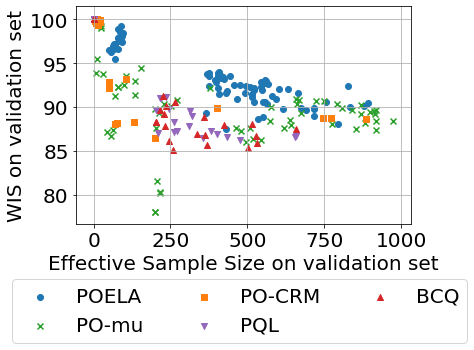

In [59]:
idx=0
seeds = [1,2,3,4,5]
ess = []
wis = []
for seed in seeds:
    for var_coeff in [0.0, 0.1, 1.0, 10.0]:
        for threshold in [0.4, 0.6, 0.8, 1.0]:
            param = {"name": "POELA", "env": "mimic45", "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
            model, val_score, train_score = get_model_from_param(param)
            wis.append(val_score[0])
            ess.append(val_score[-1])
plt.scatter(ess,wis,marker='o',color='C0',label="POELA")
ess = []
wis = []
for seed in seeds:
    for var_coeff in [0.0, 0.1, 1.0, 10.0]:
        for threshold in [0.01, 0.02, 0.05, 0.1]:
            param = {"name": "POELA-kNN", "env": "mimic45", "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
            model, val_score, train_score = get_model_from_param(param)
            wis.append(val_score[0])
            ess.append(val_score[-1])
plt.scatter(ess,wis,marker='x',color='C2',label="PO-mu")
ess = []
wis = []
for seed in seeds:
    for var_coeff in [0.0, 0.1, 1.0, 10.0]:
        param = {"name": "norm-POEM", "env": "mimic45", "thresh": 0.01, "var_coeff": var_coeff, "seed": seed}
        model, val_score, train_score = get_model_from_param(param)
        wis.append(val_score[0])
        ess.append(val_score[-1])
plt.scatter(ess,wis,marker='s',color='C1',label="PO-CRM") 
ess = []
wis = []
for seed in seeds:
    for threshold in [0.0, 0.01, 0.05, 0.1, 0.3]:
        param = {"name": "PQL", "env": "mimic45", "thresh": threshold, "seed": seed}
        model, val_score, train_score = get_model_from_param(param)
        wis.append(val_score[0])
        ess.append(val_score[-1])
plt.scatter(ess,wis,marker='v',color='C4',label="PQL") 
ess = []
wis = []
for seed in seeds:
    for threshold in [0.0, 0.01, 0.05, 0.1, 0.3]:
        param = {"name": "BCQ", "env": "mimic45", "thresh": threshold, "seed": seed}
        model, val_score, train_score = get_model_from_param(param)
        wis.append(val_score[0])
        ess.append(val_score[-1])
plt.scatter(ess,wis,marker='^',color='C3',label="BCQ")   
    
# plt.hlines(v_pib, 0, 3000, color="grey", label="Behavior Policy")
# plt.hlines(ci_pib[0], 0, len(results)-1, linestyle='--', color="grey")
# plt.hlines(ci_pib[1], 0, len(results)-1, linestyle='--', color="grey")
# plt.xscale("log")
# plt.ylim([75, 101])
plt.xlabel("Effective Sample Size on validation set")
plt.ylabel("WIS on validation set")
plt.grid(True)
#plt.title("WIS-ESS trade-off for different algorithms")
plt.legend(bbox_to_anchor=[1.2, -0.4], loc='right', ncol=3)
plt.savefig("new_plots/mimic_ess_tradeoff.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

## MIMIC Visualization

### Visualize heatmap

In [ ]:
import seaborn as sns

In [ ]:
def count_actions(dataset, model, mask=None):
    n = dataset["observations"].shape[0]
    horizon = dataset["observations"].shape[1]
    na = dataset["pibs"].shape[-1]
    
    action_counts = np.zeros(na)
    
    for idx in range(n):
        for t in range(horizon):
            if (mask is None) or (mask[idx, t] == True):
                if model is None:
                    a = dataset["actions"][idx,t,0]
                    action_counts[a] += 1
                else:
                    pie = model.get_prob(dataset["observations"][idx,t,:], dataset["estm_pibs"][idx,t,:], 
                                         dataset["nn_action_dist"][idx,t,:])
                    action_counts += pie
            
            if not dataset["not_done"][idx, t]:
                break
    return action_counts

In [ ]:
sns.palplot(sns.color_palette("Greens",12))

In [ ]:
sns.set(font_scale=1.5)

In [ ]:
cmap = sns.color_palette("Purples", n_colors=100) #“Purples” rocket_r
action_counts = count_actions(test_dataset, None).reshape((5,5))
ax = sns.heatmap(action_counts, cmap=cmap, xticklabels='auto', yticklabels='auto', vmin=0, vmax=12000)
ax.invert_yaxis()
ax.tick_params(left=False, bottom=False)
plt.xlabel("Vasopressors") 
plt.ylabel("IV fluid") 
plt.title("Physician Policy")
plt.savefig("plots/physician_heatmap.png", bbox_inches='tight')
plt.show()


for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
              npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
              bcq_rel_param, pql_rel_param]:
    model, _, _ = get_model_from_param(param)
    action_counts = count_actions(test_dataset, model).reshape((5,5))
    #print(action_counts.round(2))
    
    ax = sns.heatmap(action_counts, cmap=cmap, xticklabels='auto', yticklabels='auto', vmin=0, vmax=12000)
    ax.invert_yaxis()
    ax.tick_params(left=False, bottom=False)
    plt.xlabel("Vasopressors") 
    plt.ylabel("IV fluid") 
    plt.title(toprint(param['name']))
    plt.savefig(f"plots/{param['name']}_heatmap.png", bbox_inches='tight')
    plt.show()

In [1]:
sofa_id=34
sofa_mean = 6.0695
sofa_std = 3.3598

low_sofa = (test_dataset['observations'][:,:,sofa_id]*sofa_std+sofa_mean) < 5

NameError: name 'test_dataset' is not defined

### For different SOFA value

In [ ]:
sofa_id=34
sofa_mean = 6.0695
sofa_std = 3.3598

In [ ]:
high_sofa = (test_dataset['observations'][:,:,sofa_id]*sofa_std+sofa_mean) >= 13

In [ ]:
mid_sofa = ((test_dataset['observations'][:,:,sofa_id]*sofa_std)+sofa_mean < 15) & ((test_dataset['observations'][:,:,sofa_id]*sofa_std)+sofa_mean >= 5)

In [ ]:
low_sofa = (test_dataset['observations'][:,:,sofa_id]*sofa_std+sofa_mean) < 5

In [ ]:
action_counts = count_actions(test_dataset, None, high_sofa).reshape((5,5))
cmap = sns.color_palette("rocket_r",n_colors=100) #“Purples” rocket_r
ax = sns.heatmap(action_counts, cmap=cmap, xticklabels='auto', yticklabels='auto', vmin=0, vmax=800)
ax.invert_yaxis()
ax.tick_params(left=False, bottom=False)
plt.xlabel("Vasopressors") 
plt.ylabel("IV fluid") 
plt.title("Clinician Policy")
plt.savefig("plots/physician_highsofa_heatmap.png", bbox_inches='tight')
plt.show()

for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
              npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
              bcq_rel_param, pql_rel_param]:
    model, _, _ = get_model_from_param(param)
    action_counts = count_actions(test_dataset, model, high_sofa).reshape((5,5))
    #print(action_counts.round(2))
    
    ax = sns.heatmap(action_counts, cmap=cmap, xticklabels='auto', yticklabels='auto', vmin=0, vmax=800)
    ax.invert_yaxis()
    ax.tick_params(left=False, bottom=False)
    plt.xlabel("Vasopressors") 
    plt.ylabel("IV fluid") 
    plt.title(toprint(param['name']))
    plt.savefig(f"plots/{param['name']}_highsofa_heatmap.png", bbox_inches='tight')
    plt.show()

In [ ]:
action_counts = count_actions(test_dataset, None, mid_sofa).reshape((5,5))
ax = sns.heatmap(action_counts, cmap="Blues", xticklabels='auto', yticklabels='auto')
ax.invert_yaxis()
ax.tick_params(left=False, bottom=False)
plt.xlabel("Vasopressors") 
plt.ylabel("IV fluid") 
plt.title("Physician Policy")
plt.savefig("plots/physician_midsofa_heatmap.png", bbox_inches='tight')
plt.show()

for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
              npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
              bcq_rel_param, pql_rel_param]:
    model, _, _ = get_model_from_param(param)
    action_counts = count_actions(test_dataset, model, mid_sofa).reshape((5,5))
    #print(action_counts.round(2))
    
    ax = sns.heatmap(action_counts, cmap="Blues", xticklabels='auto', yticklabels='auto')
    ax.invert_yaxis()
    ax.tick_params(left=False, bottom=False)
    plt.xlabel("Vasopressors") 
    plt.ylabel("IV fluid") 
    plt.title(toprint(param['name']))
    plt.savefig(f"plots/{param['name']}_midsofa_heatmap.png", bbox_inches='tight')
    plt.show()

In [ ]:
action_counts = count_actions(test_dataset, None, low_sofa).reshape((5,5))
ax = sns.heatmap(action_counts, cmap="Greens", xticklabels='auto', yticklabels='auto')
ax.invert_yaxis()
ax.tick_params(left=False, bottom=False)
plt.xlabel("Vasopressors") 
plt.ylabel("IV fluid") 
plt.title("Physician Policy")
plt.savefig("plots/physician_lowsofa_heatmap.png", bbox_inches='tight')
plt.show()

for param in [ours_rel_param, ours_novar_rel_param, knn_rel_param, knn_novar_rel_param, 
              npoem_rel_param, npoem_novar_param, nomask_rel_param, nomask_novar_param, 
              bcq_rel_param, pql_rel_param]:
    model, _, _ = get_model_from_param(param)
    action_counts = count_actions(test_dataset, model, low_sofa).reshape((5,5))
    #print(action_counts.round(2))
    
    ax = sns.heatmap(action_counts, cmap="Greens", xticklabels='auto', yticklabels='auto')
    ax.invert_yaxis()
    ax.tick_params(left=False, bottom=False)
    plt.xlabel("Vasopressors") 
    plt.ylabel("IV fluid") 
    plt.title(toprint(param['name']))
    plt.savefig(f"plots/{param['name']}_lowsofa_heatmap.png", bbox_inches='tight')
    plt.show()